## ПРОЕКТ – A/A ТЕСТЫ И ПРОВЕРКА КАЧЕСТВА СИСТЕМ СПЛИТОВАНИЯ
Выполнил: Анкушев Владислав

### Описание задания
- А/А-тестирование мобильного приложения.   
- Необходимо посчитать результаты A/A-теста, проверяя метрику качества FPR (будем проверять на конверсии в покупку).   
- Известно, что сплит-система сломана.   
- Требуется проверить утверждение о поломке и найти ее причины, если сплит-система действительно сломана

### Описание колонок
- **experimentVariant** – вариант эксперимента
- **version** – версия приложения
- **purchase** – факт покупки


---
### Задача
1. Запустите A/A-тест


2. Посчитайте FPR на уровне альфа = 0.05 (ставьте подвыборки без возвращения объемом 1000).  
    Вы увидите, что FPR > альфа! Нам нужно наоборот – чтобы было меньше.
    
    
3. Найдите причины поломки сплит-системы, ориентируясь на результаты эксперимента (подсказка: найдите аномалию в версии приложения)


4. Напишите выводы, которые можно сделать на основе анализа результатов A/A-теста


### Ответ: как найти причины поломки?

Вам доступна версия мобильного приложения (МП) каждого пользователя. Эту полезную информацию можно использовать для исследования проблемы:

1. Посчитайте конверсию (коэффициент покупок), группируя по варианту и версии МП. Возможно уже станет ясно где именно причины поломки


2. Посчитайте pvalue для каждой версии МП


3. Найдите версии, где pvalue < 0.05


4. Исключите версию с pvalue < 0.05 из основного датафрейма


5. Повторно запустите расчет FPR через A/A. Теперь FPR < альфа


6. Вы нашли поломку

---
### Загружаем библиотеки

In [50]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import itertools
from scipy.stats import norm
from statsmodels.stats.contingency_tables import StratifiedTable
from statsmodels.graphics.mosaicplot import mosaic
from tqdm.auto import tqdm
import seaborn as sns
sns.set(rc={'figure.figsize':(10,8)})

### Загружаем дата-сет 

In [5]:
#Загрузка дата-сета
data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-v-ankushev-18/Statistics/hw_aa (1).csv', sep =';')

#Удаляем айди колонку 
data = data.drop(columns = ['Unnamed: 0'])

### Сразу же проверим A/A-тест

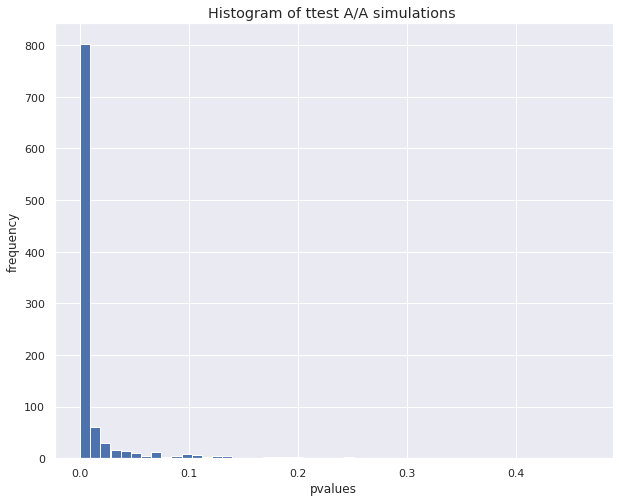

0.927

In [51]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = data[data.experimentVariant == 0]['purchase'].sample(n_s, replace = False).values
    s2 = data[data.experimentVariant == 1]['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

#### Интепретация 
1. Количество стат.значимых различий очень большое!   


2. Практически в 95% случаев мы получаем стат. значимый результат 

### Поиск проблемы
Посмотрим на коэф. конверсии в двух версиях | группах эксперимента 


In [52]:
#Количество всех наблюдений
num_all_data = data.purchase.count()

In [53]:
#Группируем данные 
conversion = data.groupby(['experimentVariant', 'version'], as_index = False) \
    .agg({'purchase' : 'count'}) 

#Создаем колонку и считаем процент конверсии
conversion['conversion_rate'] = round(conversion.purchase / num_all_data,2) * 100

#Выводим данные 
conversion

,experimentVariant,version,purchase,conversion_rate
0,0,v2.8.0,41283,33.0
1,0,v2.9.0,11921,9.0
2,0,v3.7.4.0,4204,3.0
3,0,v3.8.0.0,5694,4.0
4,1,v2.8.0,41552,33.0
5,1,v2.9.0,12033,9.0
6,1,v3.7.4.0,4221,3.0
7,1,v3.8.0.0,6110,5.0


#### Интерпретация:
- В обеих группах версия – "v2.8.0" имеет наибольшую конверсию.   
    Возможно, сплит-система ошиблась и произошел перевес клиентов с версией v2.8.0

### Для более точной оценки воспользуемся критерием Кохрана-Мантеля-Ханзеля
- 2: группа
- 2: купил / не купил
- n: версия продукта

In [54]:
StratifiedTable.from_data('experimentVariant', 'purchase', 'version', data).summary()

,Estimate,LCB,UCB
Pooled odds,2.300,2.161,2.447
Pooled log odds,0.833,0.771,0.895
Pooled risk ratio,1.031,,
,,,
,Statistic,P-value,
Test of OR=1,734.655,0.000,
Test constant OR,1256.880,0.000,
,,,
Number of tables,4,,
Min n,8425,,


**Интерпретация**:   
Согласно полученной таблице можно сказать, что покупка связана с переменной группы.   
Причем эта связь разная, в зависимости от уровня версии продукта. 

### Построим heatmap, чтобы посмотреть, какие группы различаются

Нужно склеить колонки experimentVariant и purchase (сделать их как одну, поскольку heatmap имеет 2д размер)

In [55]:
data['experimentVariant2'] = np.where(data['experimentVariant'] == 0, 'control', 'experiment')
data['purchase_2'] = np.where(data['purchase'] == 0, 'no', 'buy')
data['group'] = data['experimentVariant2'] + "_" + data.purchase_2.astype(str)
data = data.drop(columns = ['experimentVariant2', 'purchase_2'])
data

,uid,experimentVariant,version,purchase,group
0,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0,experiment_no
1,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0,control_no
2,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0,experiment_no
3,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0,experiment_no
4,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0,experiment_no
...,...,...,...,...,...
127013,d1f082ede77b17a99a9b0b240daf7bdf,0,v2.8.0,0,control_no
127014,94f0d540830ccdc6b29c1938eea445cc,0,v2.8.0,0,control_no
127015,709f74cf9721328e98be6f216e8a05a8,1,v2.9.0,0,experiment_no
127016,1767ae3f8ffec269d9ed0ac0ede68d90,1,v2.8.0,0,experiment_no


(<Figure size 720x576 with 3 Axes>,
 {('experiment_no', 'v2.8.0'): (0.0,
   0.0,
   0.4693722087564176,
   0.6488582029587621),
  ('experiment_no', 'v2.9.0'): (0.0,
   0.6521585329917653,
   0.4693722087564176,
   0.1828426360557824),
  ('experiment_no', 'v3.7.4.0'): (0.0,
   0.8383014990805511,
   0.4693722087564176,
   0.0647107494944626),
  ('experiment_no', 'v3.8.0.0'): (0.0,
   0.906312578608017,
   0.4693722087564176,
   0.09368742139198308),
  ('control_no', 'v2.8.0'): (0.47429831713080184,
   0.0,
   0.47773377141302725,
   0.6629810096659681),
  ('control_no', 'v2.9.0'): (0.47429831713080184,
   0.6662813396989713,
   0.47773377141302725,
   0.17732756698572555),
  ('control_no', 'v3.7.4.0'): (0.47429831713080184,
   0.8469092367177002,
   0.47773377141302725,
   0.06352991974685768),
  ('control_no', 'v3.8.0.0'): (0.47429831713080184,
   0.9137394864975611,
   0.47773377141302725,
   0.08626051350243887),
  ('control_buy', 'v2.8.0'): (0.9569581969182134,
   0.0,
   0.01172014

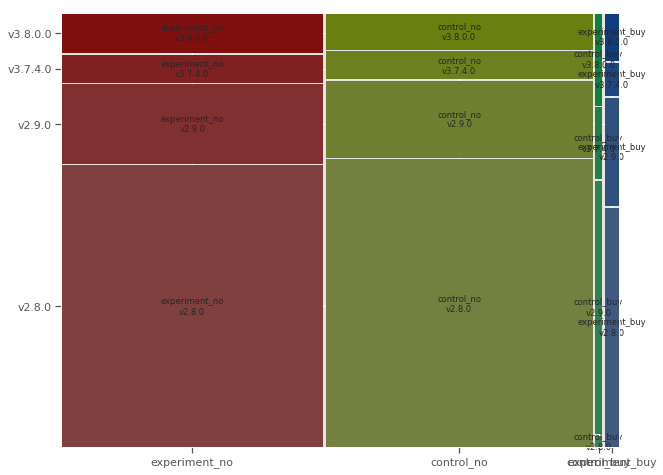

In [57]:
#Строим хит-мап
mosaic(data, ['group', 'version'])

#### Получился дурацкий, но информативный график:
1. Те, кто не покупают > тех, кто покупают 
2. Самый большой перевес приходится на версию v2.8.0
3. Необходимо проверить результаты A/A теста без этой версии!

### Попробуем удалить клиентов с этой версией и посмотрим на результаты A/A теста

In [65]:
#Запихнем это в фунцию

def a_a_test(version):
    n = 100000
    simulations = 1000
    n_s = 1000
    res = []


# Запуск симуляций A/A теста
    for i in tqdm(range(simulations)):
        s1 = data[(data.experimentVariant == 0) & (data.version != version)]['purchase'].sample(n_s, replace = False).values
        s2 = data[(data.experimentVariant == 1) & (data.version != version)]['purchase'].sample(n_s, replace = False).values
        res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

    plt.hist(res, bins = 50)
    plt.style.use('ggplot')
    plt.xlabel('pvalues')
    plt.ylabel('frequency')
    plt.title("Histogram of ttest A/A simulations ")
    plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
    p_value = sum(np.array(res) <0.05) / simulations
    
    return p_value

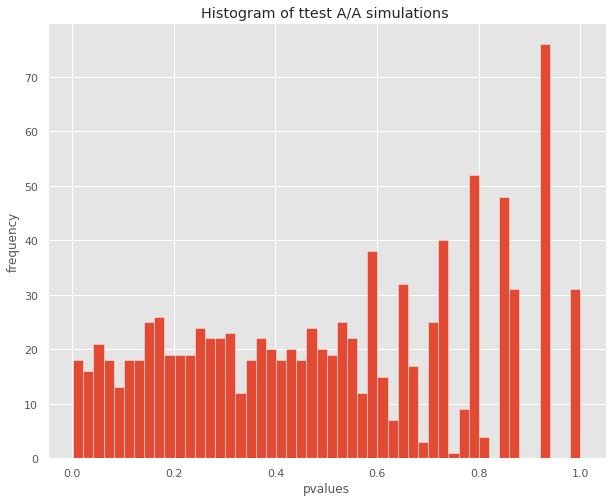

0.039

In [66]:
a_a_test('v2.8.0')

### Интерпретация: 
- FPR < 0.05. Теперь только в 4 случаях мы получаем стат. значимый результат. 


- Возможно, вся проблема сплит системы кроется в версии – "v2.8.0", поскольку по показателю конверсии и КМХ критерия эта группа является выбросом относительно других


### Вывод:
- Необходимо исправить алгоритм показа теста для версии v2.8.0